# QGraphs - A quantum model for digraph representation and navigation

*This notebook explores creation and use of* ***QGgraphs (Quantum Digraphs)*** *in* ***Networkx+PennyLane+PyTorch**.*

**By:** Jacob Cybulski<br>
**Date:** August 2024<br>
**Aims:** The goal of this notebook is to test some *Quantum Digraph (QGraphs)* features and functions.<br/>
**Refs:**
- Brownlee, J., 2019. <a href="https://machinelearningmastery.com/divergence-between-probability-distributions/" target="_blank">How to Calculate the KL Divergence for Machine Learning</a>. MachineLearningMastery.com.
- <a href="https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence" target="_blank">Kullback–Leibler divergence</a>, Wikipedia.
- <a href="https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a>, Wikipedia.
- <a href="https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html" target="_blank">KLDivLoss</a>. PyTorch docs.

A *QGraph* is a weighted directed graph, which excludes parallel edges (in the same direction), but allowing loops. It defines a stochastic navigation between its verteces, where the probability of taking a particular edge from a given vertex is given by the edge weight.

Formally, a qgraph $G$ is defined as a weighted digraph:

$$G = \{V, E, w\},$$

where $V = \{v\}$ is a set of digraph vertices, $E = \{(v_s,v_t) : v_s, v_t \in V\}$ is a set of directional edges, and $|V|$ being the number of vertices in $V$.<br/>
Function $w(V, V)\rightarrow R$ assigns weights to all edges, such that:

$$w(v_s, v_t) =
\left\{
	\begin{array}{ll}
		p(v_t | v_s)  & \forall_{v_s, v_t \in V,\;(v_s, v_t) \in E}\\
		0 & \forall_{v_s, v_t \in V,\;(v_s, v_t) \notin E}
	\end{array}
\right.
$$

where $p(v_t | v_s)$ is the probability of navigating over the edge $(v_s, v_t)$ when arrived at the source vertex $v_s$ to its target $v_t$ (including the self), and:

$$\forall_{(v_s, v_t) \in E}\: \sum_{v_t} w(v_s, v_t) = 1.$$

This means that every digraph vertex must have at least one outgoing link.

An arbitrary weighted digraph $G = \{V, E, w(V, V)\}$ can be expanded to become a QGraph $G^{'} = \{V^{'}, E^{'}, w^{'}(V^{'}, V^{'})\}$ by adding loops to all verteces $v$ with outdegree 0, and rescaling weights to add up to 1. Now:

$$\forall_{v \in V}\; v \in V^{'} \land \forall_{e \in E}\; e \in E^{'}$$
$$\forall_{v_s \in V}\;(\forall_{v_t \in V}\;(v_s, v_t) \notin E) \Longrightarrow (v_s, v_s) \in E^{'} \land w^{'}(v_s, v_s) = 1$$
$$\forall_{(v_s, v_t) \in E}\; w^{'}(v_s, v_t) = \frac{w(v_s, v_t)}{\sum_{(v_s, v_i) \in E}\; w(v_s, v_i)}$$

In [1]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/miniconda3/envs/pl-cuda12/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/site-packages',
 '.',
 '..']

In [2]:
### General libraries

import matplotlib.pyplot as plt
import matplotlib.patches as pltpat
import pylab
import math
from IPython.display import clear_output

from matplotlib import set_loglevel
set_loglevel("error")

%matplotlib inline

## Networkx digraph manipulation

### Digraph drawing

In [3]:
### Draw a digraph
def draw_digraph(G, ax=None, weight_prec=3, font_size=12):
    pos = nx.shell_layout(G)
    # pos = nx.kamada_kawai_layout(G)
    # pos = nx.planar_layout(G)
    # pos = nx.spring_layout(G)
    # cstyle = "arc3,rad=0.3"
    cstyle = "arc3"
    nx.draw_networkx_nodes(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=font_size, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color="grey", ax=ax, connectionstyle=cstyle)

In [4]:
### Draw a weighted digraph
def draw_weighted_digraph(G, attr_name, ax=None, weight_prec=3, font_size=12):
    pos = nx.shell_layout(G)
    # pos = nx.kamada_kawai_layout(G)
    # pos = nx.planar_layout(G)
    # pos = nx.spring_layout(G)
    # cstyle = "arc3,rad=0.3"
    cstyle = "arc3"
    nx.draw_networkx_nodes(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=font_size, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color="grey", ax=ax, connectionstyle=cstyle)

    labels = {tuple(edge) : f"{np.round(attrs[attr_name], weight_prec)}" for *edge, attrs in G.edges(data=True)}
    
    nx.draw_networkx_edge_labels(
        G,
        pos,
        labels,
        label_pos=0.35,
        font_color="blue",
        bbox={"alpha": 0},
        verticalalignment='baseline', # top, bottom, center, center_baseline
        ax=ax,
    )

### Digraph generation

In [5]:
from pylab import *
import json
import networkx as nx
from networkx.readwrite import json_graph

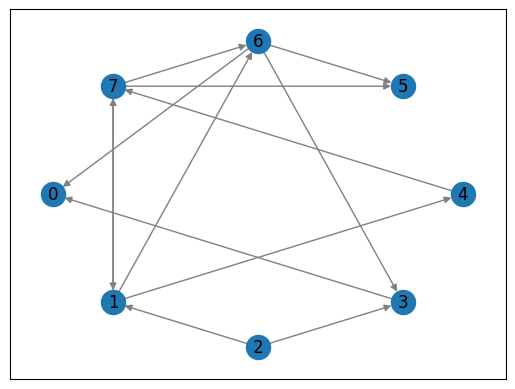

In [6]:
### Create a random graph
node_no = 8
edge_p = 0.25
g = nx.gnp_random_graph(node_no, edge_p, directed=True)
draw_digraph(g)

### Digraph saving and loading

In [7]:
import os

In [8]:
### Saving of a graph to a file
def save_digraph(G, fpath, vers=0):
    os.makedirs(os.path.dirname(fpath), exist_ok=True)
    g_node_links = nx.node_link_data(G)
    with open(f'{fpath}', 'w') as f:
        json.dump(g_node_links, f)
        f.close()

vers = 0
g_path = f'sample_graphs/digraph_{node_no}_{edge_p}_v{vers}.json'
save_digraph(g, g_path)
print(f'Saved graph in file: {g_path}')

Saved graph in file: sample_graphs/digraph_8_0.25_v0.json


Loaded graph from file: sample_graphs/digraph_8_0.25_v5.json


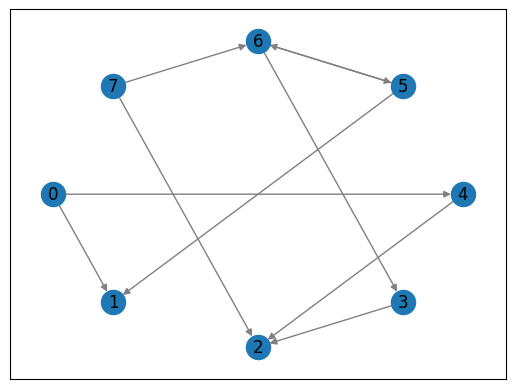

In [9]:
### Loading a graph from a file
def load_digraph(fpath):
    if not os.path.exists(fpath):
        print(f'*** ERROR: The digraph file does not exist or is corrupted: {fpath}')
        return nx.null_graph()
    else:
        try:
            f = open(fpath, 'r')
        except OSError:
            print(f'*** ERROR: Could not open/read the digraph file: {fpath}')
            return nx.null_graph()
        with f:
            with open(f'{fpath}', 'r') as f:
                G_node_links = json.load(f)
                f.close()
            G = nx.node_link_graph(G_node_links)
            return G

g_path = 'sample_graphs/digraph_8_0.25_v5.json'
g_sel = load_digraph(g_path)
draw_digraph(g_sel)
print(f'Loaded graph from file: {g_path}')

In [10]:
nx.node_link_data(g_sel)

{'directed': True,
 'multigraph': False,
 'graph': {},
 'nodes': [{'id': 0},
  {'id': 1},
  {'id': 2},
  {'id': 3},
  {'id': 4},
  {'id': 5},
  {'id': 6},
  {'id': 7}],
 'links': [{'source': 0, 'target': 1},
  {'source': 0, 'target': 4},
  {'source': 3, 'target': 2},
  {'source': 4, 'target': 2},
  {'source': 5, 'target': 1},
  {'source': 5, 'target': 6},
  {'source': 6, 'target': 3},
  {'source': 6, 'target': 5},
  {'source': 7, 'target': 2},
  {'source': 7, 'target': 6}]}

### Generate a QGraph for modeling

***Creation of a quantum digraph includes three stages:***<br/>
- *Converting an undirected graph to an adjacency matrix*
- *Changing all undirected edges to weighted directed edges*
- *Expanding a digraph to a QGraph (quantum digraph) by adding loops to stop vertices*

Note that on measurement, probabilities of navigation from a vertex to all possible targets adds to 1.

In [11]:
### Convert an adjacency of a unweighted graph to adjacency of a weighted graph
#   Two methods of generating weights:
#   - rand: random weights are generated
#   - scale: existing weights are scaled
def digraph_adj_weigh(unw_adj, method='rand'):
    w_adj = unw_adj.copy().astype(float)
    for r in range(unw_adj.shape[0]):
        r_sum = sum(unw_adj[r])
        r_nz = np.count_nonzero(unw_adj[r])
        if r_sum != 0.0:
            # Edges available - generate weights
            if method == 'rand':
                nz_weights = np.random.random(r_nz)
            else:
                nz_weights = np.array([num*1.0 for num in unw_adj[r] if num])
            nz_weights /= nz_weights.sum()
            w_no = 0
            for c in range(unw_adj.shape[1]):
                if unw_adj[r, c] > 0:
                    w_adj[r, c] = nz_weights[w_no]
                    w_no += 1
    return w_adj

### Expand a weighted digraph to eliminate vertices with out-dgree=0
def digraph_adj_expand(w_adj):
    exp_adj = w_adj.copy().toarray()
    for r in range(w_adj.shape[0]):
        r_sum = np.count_nonzero(w_adj[r].toarray())
        if r_sum == 0:
            # No outgoing links - create a loop
            exp_adj[r, r] = 1.0
    return exp_adj

### Prepare a quantum digraph for quantum modeling
#   Convert an undirected graph into QGraph
def digraph_expanded_and_weighed(g, method='rand'):
    g_adj = nx.adjacency_matrix(g)
    g_adj_expanded = digraph_adj_expand(g_adj)
    g_adj_weighed = digraph_adj_weigh(g_adj_expanded, method=method)
    g_new = nx.DiGraph(g_adj_weighed)
    return g_new

### Testing generation of QGraphs

In [12]:
### We are going to use the previously loaded digraph g_sel
g_sel_node_no = g_sel.number_of_nodes()
g_sel_edge_no = g_sel.number_of_edges()
print(f'Digraph of {g_sel_node_no} nodes and {g_sel_edge_no} edges')

Digraph of 8 nodes and 10 edges


#### First let us do this step by step and observe results

In [13]:
### Convert a graph to an adjacency matrix
import scipy as sci # Not used as yet
adj_sel = nx.adjacency_matrix(g_sel)
adj_sel.toarray()

/tmp/ipykernel_280988/2114991748.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_sel = nx.adjacency_matrix(g_sel)


array([[0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0]])

In [14]:
### Expand the digraph to eliminate stop vertices (out-degree=0)
adj_exp = digraph_adj_expand(adj_sel)
np.around(adj_exp, 3)

array([[0, 1, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0]])

In [15]:
### Generate edge probability weights (adding to 1.0)
adj_w = digraph_adj_weigh(adj_exp, method='scale') # rand scale
np.around(adj_w, 3)

array([[0. , 0.5, 0. , 0. , 0.5, 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0. , 0. , 0. , 0.5, 0. ],
       [0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. ],
       [0. , 0. , 0.5, 0. , 0. , 0. , 0.5, 0. ]])

#### Now let us generate a QGraph in a single step

/tmp/ipykernel_280988/183446805.py:37: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  g_adj = nx.adjacency_matrix(g)


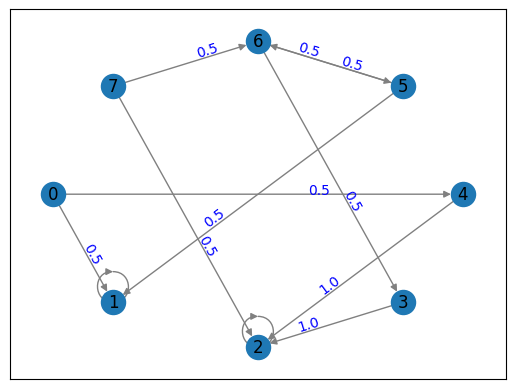

In [16]:
### Test graph generation in one step
g_new = digraph_expanded_and_weighed(g_sel, method='scale') # scale or rand
# nx.draw(g_new, with_labels = True)
draw_weighted_digraph(g_new, 'weight', ax=None)

In [17]:
nx.node_link_data(g_new)

{'directed': True,
 'multigraph': False,
 'graph': {},
 'nodes': [{'id': 0},
  {'id': 1},
  {'id': 2},
  {'id': 3},
  {'id': 4},
  {'id': 5},
  {'id': 6},
  {'id': 7}],
 'links': [{'weight': 0.5, 'source': 0, 'target': 1},
  {'weight': 0.5, 'source': 0, 'target': 4},
  {'weight': 1.0, 'source': 1, 'target': 1},
  {'weight': 1.0, 'source': 2, 'target': 2},
  {'weight': 1.0, 'source': 3, 'target': 2},
  {'weight': 1.0, 'source': 4, 'target': 2},
  {'weight': 0.5, 'source': 5, 'target': 1},
  {'weight': 0.5, 'source': 5, 'target': 6},
  {'weight': 0.5, 'source': 6, 'target': 3},
  {'weight': 0.5, 'source': 6, 'target': 5},
  {'weight': 0.5, 'source': 7, 'target': 2},
  {'weight': 0.5, 'source': 7, 'target': 6}]}

## PennyLane Implementation

A QGraph $G = \{V, E, w\}$, with $v \in V$ as the vertex unique numeric identifier, represents a parameterised function $f_\theta(V) \rightarrow V$,
which can be realised as a quantum circuit $U(v, \theta)$ measured projectively with observable $\mathcal{M}$:

$$
\begin{gather}
    f_\theta(v) = tr[ \mathcal{M} U(v, \theta)^\dagger \vert 0 \rangle \langle 0 \vert U(v, \theta) ],\quad and\\
    U(v, \theta) = A(\theta)S(v).
\end{gather}
$$

$S(v)$ is a feature map and $A(\theta)$ an ansatz with trainable parameters $\theta = (\theta_0, \theta_1, ..., \theta_n)$.
The ansatz can be trained on the graph edges $e = (v_s, v_t) \in E$ and their weights $w(v_s, v_t)$, such that $v_s$ would be passed as the input to $U(v, \theta)$, which is subsequently executed repeatedly to produce a distribution of possible outcomes $v_t$, each approximating the probability $p(v_t|v_s)$ aimed to approach the value of its edge weight $w(v_s, v_t)$.

The circuit $U(v, \theta)$ training can be facilitated by the loss function able to measure the difference between two probability distributions of possible paths from a particular vertex $v_s$, i.e. the observed probability distribution $P(v_s) = \{p(v_t | v_s) : \forall_{v_t \in V}\}$ of each run of $U(v_s, \theta)$ and the expected distribution $W(v_s) = \{w(v_s, v_t) : \forall_{e=(v_s, v_t) \in E}\}$. 
The standard $L1(W(v_s), P(v_s))$ loss function could support the model training, leading to $MAE(W, P)$ cost measured between all possible vertex combinations in the probability distributions. 
However, the complexity of such a cost calculation would be $O({\vert V \vert} * 2^{\vert V \vert})$.

A more suitable loss function could be *Kullback-Leibler Divergence*, stated as a function $KL(W(v_s) || P(v_s))$ representing the magnitude of our "surprise" when the model adopts the observed distribution $P(v_s)$ instead of the actual distribution $W(v_s)$. The $KL$ loss function for the vertex $v_s$ can be defined as follows (adapted from Brownlee 2019):

$$KL(W(v_s) || P(v_s)) = \sum_{(v_s, v_t) \in E} w(v_s, v_t) * log(w(v_s, v_t) / p(v_t | v_s))$$

Therefore, the cost (average loss) of differences between observed and expected navigations for all digraph vertices is:

$$
\begin{array}{ll}
    KL(W || P) 
    &=&\frac{1}{|V|}\sum_{v_s \in V}\;KL(W(v_s) || P(v_s))\\
    &=&\frac{1}{|V|}\sum_{v_s \in V}\sum_{(v_s, v_t) \in E}\; w(v_s, v_t) * log(w(v_s, v_t) / p(v_t | v_s)) \\
    &=&\frac{1}{|V|}\sum_{(v_s, v_t) \in E}\; w(v_s, v_t) * log(w(v_s, v_t) / p(v_t | v_s))
\end{array}
$$

For the $KL$ function to be computable, we only consider pairs of vertices $(v_s, v_t)$ that have non-zero weights $w(v_s, v_t)$ and non-zero probability $p(v_t | v_s)$. 
Also note that $KL$ ignores those vertex pairs which emerge as "probably navigable" during model training, but not actually connected by an edge, meaning their pairwise weight is zero. 
This leads to the more selective cost calculation, with its complexity to be only $O(|E|)$, limited by $O(|V|^2)$ in the worst case scenario.

*Kullback-Leibler Divergence* is not symmetrical, i.e. $KL(W || P) \neq KL(P || W)$, and tends to generate very large negative values. Therefore, a related *Jensen-Shannon Divergence* could be used as a replacement. $JS$ loss function can be defined as follows (adapted from Brownlee 2019):

$$
\begin{array}{ll}
    &&\text{the loss function is:}\\
    \\
    &&for\; M(v_s) = 0.5 * (W(v_s) + P(v_s)),\\
    JS(W(v_s) || P(v_s)) 
    &=&0.5 * KL(W(v_s) || M(v_s)) + 0.5 * KL(P(v_s) || M(v_s)),\\
    \\
    &&\text{and the cost (average loss) is:}\\
    \\
    &&for\; M = \frac{0.5}{|V|}\; (W + P),\\
    JS(W || P) 
    &=&\frac{1}{|V|}\sum_{v_s \in V}\;JS(W(v_s) || P(v_s))\\
    &=&0.5 * \frac{1}{|V|}\sum_{v_s \in V}\;(KL(W(v_s) || M(v_s)) + KL(P(v_s) || M(v_s))) \\
    &=&0.5 * (\frac{1}{|V|}\sum_{v_s \in V}\;KL(W(v_s) || M(v_s)) + \frac{1}{|V|}\sum_{v_s \in V}\;KL(P(v_s) || M(v_s))) \\
    &=&0.5 * (KL(W || M) + KL(P || M))
\end{array}
$$

As noted by Brownlee (2019), when compared with KL divergence, $JS(W(v_s) || P(v_s))$, and consequently $JS(W || P)$, is a more useful measure for model training - it is smooth and normalized, and, when using the base-2 logarithm, its scores are in the range from 0 (identical) to 1 (maximally different).

Note that in PyTorch, the class <a href="https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html" target="_blank">KLDivLoss</a> (see examples) defines the KL function, which takes as its arguments *input* (P), which is the result produced by a model (e.g. NN), and a *target* (W) which defines observations drawn from the data.

In [18]:
### PennyLane and Torch

import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp

# Pytorch imports
import torch
from torch import nn, tensor, optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# Utils import
from utils.Circuits import *

jax.config.update("jax_enable_x64", True)

### Jensen-Shannon Divergence

Refs: 
- Amin Jun + Renly Hou, <a href="https://discuss.pytorch.org/t/jensen-shannon-divergence/2626/9" target="_blank">JSD implementation</a>, pytorch.org
- johnball, <a href="https://stats.stackexchange.com/questions/303735/jensen-shannon-divergence-for-multiple-probability-distributions">Multiple JSD implementation</a>, stackexchange.com


In [19]:
### Implementation of JSD
#   From: Amin Jun + Renly Hou: 
#         https://discuss.pytorch.org/t/jensen-shannon-divergence/2626/9
#   Note that I am taking softmax before passing p and q to my JSD instance. 
#   Also, note that this implementation works with matrices as well, 
#   since in the beginning I’m flattening both tensors.
#   Also, note that I’m passing log_target=True, which means the m should be in log-space. 
#   This makes the implementation slightly faster, because we’re computing the m.log() only once.
class JSD(nn.Module):
    def __init__(self):
        super(JSD, self).__init__()
        self.kl = nn.KLDivLoss(reduction='batchmean', log_target=True)

    def forward(self, p: torch.tensor, q: torch.tensor):
        p, q = p.view(-1, p.size(-1)), q.view(-1, q.size(-1))
        m = (0.5 * (p + q)).log()
        return 0.5 * (self.kl(m, p.log()) + self.kl(m, q.log()))

### Calculates the JSD for multiple probability distributions
#   See johnball: https://stats.stackexchange.com/questions/303735/
#                    jensen-shannon-divergence-for-multiple-probability-distributions
#   Also see: https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
class multi_JSD(nn.Module):
    def __init__(self):
        super(multi_JSD, self).__init__()
        
    # JSD function
    def jsd(self, prob_dists):
        weight = 1/len(prob_dists) # Set weights to be uniform
        js_left = np.zeros(len(prob_dists[0]))  
        js_right = 0
        for pd in prob_dists:
            js_left += pd * weight
            js_right += weight * self.entropy(pd, normalize=False)
    
        jsd = self.entropy(js_left, normalize=False)-js_right
        return jsd
    
    # Entropy function
    def entropy(self, prob_dist, normalize=True):
        entropy = -sum([p * math.log2(p) for p in prob_dist if p != 0])
        if normalize:
            max_entropy = math.log2(prob_dist.shape[0])
            return entropy/max_entropy
        return entropy

### Utilities

In [20]:
def draw_circuit(circuit, fontsize=20, style='pennylane', expansion_strategy=None, scale=None, title=None, decimals=2):
    def _draw_circuit(*args, **kwargs):
        nonlocal circuit, fontsize, style, expansion_strategy, scale, title
        qml.drawer.use_style(style)
        if expansion_strategy is None:
            expansion_strategy = circuit.expansion_strategy
        fig, ax = qml.draw_mpl(circuit, decimals=decimals, expansion_strategy=expansion_strategy)(*args, **kwargs)
        if scale is not None:
            dpi = fig.get_dpi()
            fig.set_dpi(dpi*scale)
        if title is not None:
            fig.suptitle(title, fontsize=fontsize)
        plt.show()
    return _draw_circuit

In [21]:
def digit_list(a, n_bits):
    return np.array([int(i) for i in f'{a:0{n_bits}b}'])

a = 0b01101001
b = 0b01011001
n_bits = 8

print(digit_list(a, 8))
print(digit_list(b, 8))

[0 1 1 0 1 0 0 1]
[0 1 0 1 1 0 0 1]


### Create a qgraph circuit

The qgraph circuit will be a simple QNN. A few different approaches will be tested as determined by the input encoding.
- Simple encoding, with each vertex mapped into a qubit - requires $|V|$ qubits
- Basis encoding, with each vertex number mapped into a binary qubit representation - requires $log_2(|V|)$ qubits

In [ ]:
### QGraph wrapper with a static data structure and variant input and weights only
#   wires: 
def qgraph_basis(wires, n_bits, n_extra, n_layers=1, rot='Ry'):
    def _qgraph_circ(inputs, weights):
        # inputs: Number of vertex id bits = log2(|V|)
        # output: size of n_latent
        nonlocal wires, n_bits, n_extra, n_layers, rot
        latent_wires = wires[0:n_latent]
        trash_wires = wires[n_latent:n_latent+n_trash]
        data_wires = latent_wires + trash_wires
        qml.AngleEmbedding(inputs, rotation='Y', wires=data_wires)
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, rotation=qml.RY, wires=wires)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=wires)
        return [qml.expval(qml.PauliZ(wires=w)) for w in latent_wires]
        # return qml.probs(wires=latent_wires)
    return _hybrid_qae_in

def qgraph_basis_shape(n_latent, n_trash, n_extra, n_layers=1, rot='Ry'):
    n_wires = n_latent + n_trash + n_extra
    if rot == 'Ry':
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    elif  rot == 'Rxyz':
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
    return shape

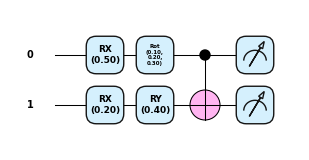

In [20]:
##### Just testing an arbitrary circuit creation

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights_0, weight_1):
    qml.RX(inputs[0], wires=0)
    qml.RX(inputs[1], wires=1)
    qml.Rot(*weights_0, wires=0)
    qml.RY(weight_1, wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.Z(0)), qml.expval(qml.Z(1))

draw_circuit(qnode, scale=0.5)([0.5, 0.2], [0.1, 0.2, 0.3], 0.4)

## Versions

**V1** Commenced work on *QGraphs*
- **V1_00 (240808)** Initial graph representation in *networkx*<br/>
  Added an extra vertex for redirection from stop vertices
- **V1_01 (240814)** Added mathematical formulation
- **V1_02 (240816)** Changed representation and maths<br/>
  Added loops for redirection from stop vertices
- **V1_03 (240824)** Initial work on graph training in *PennyLane*

## System

In [21]:
!pip list | grep -e torch -e PennyLane -e networkx

networkx                  2.8.8
PennyLane                 0.36.0
PennyLane_Lightning       0.36.0
PennyLane_Lightning_GPU   0.36.0
PennyLane-Rigetti         0.36.0
torch                     2.3.1+cu121
torchaudio                2.3.1+cu121
torchsummary              1.5.1
torchvision               0.18.1+cu121
